#The STL-10 dataset
STL-10 (Self-Taught Learning 10) is an image dataset derived from ImageNet

100,000 unlabeled images. 

13,000 labeled images from 10 object classes, among which 5,000 images are partitioned for training while the remaining 8,000 images for testing

All the images are color images with 96×96 pixels in size

In [ ]:
import os
import numpy as np
from imageio import imsave
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import STL10
import torchvision.transforms as tt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
%matplotlib inline
import time
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = STL10(root='data', download=True, transform=tt.ToTensor())
test_dataset = STL10(root='data', split ='test', transform=tt.ToTensor())

Files already downloaded and verified


In [ ]:
#The No of images in the training and testing dataset List the no of output classes in the dataset
dataset_size = len(dataset)
train_ds = dataset
test_dataset_size = len(test_dataset)
valid_ds = test_dataset
classes = dataset.classes
dataset_size,train_ds.data.shape,test_dataset_size,valid_ds.data.shape, dataset.classes,len(dataset.classes)

(5000,
 (5000, 3, 96, 96),
 8000,
 (8000, 3, 96, 96),
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'],
 10)

In [ ]:
'''
Alternate way to load data without using torchvision.datasets
download the STL10 tar.gz file and unzip it
'''
# import urllib.request
# import tarfile
#import errno
# DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# filename = DATA_URL.split('/')[-1]                   #Extracts filename from url 
# filepath, _ = urllib.request.urlretrieve(DATA_URL, filename)
# tarfile.open(filepath, 'r:gz').extractall()

# path to the directory including the binary data
# DATA_PATH = './stl10_binary/'

# # path to save images
# SAVE_PATH = './img/'

# def read_labels(path_to_labels):
#     with open(path_to_labels, 'rb') as f:
#         labels = np.fromfile(f, dtype=np.uint8)
#         return labels

# def read_all_images(path_to_data):
#     with open(path_to_data, 'rb') as f:
#         everything = np.fromfile(f, dtype=np.uint8)
#         images = np.reshape(everything, (-1, 3, 96, 96))
#         images = np.transpose(images, (0, 3, 2, 1))
#         return images

# def save_images(images, labels, des_path):
#     i = 0
#     for image in images:
#         label = labels[i]
#         directory = os.path.join(des_path, str(label))
#         try:
#             os.makedirs(directory, exist_ok=True)
#         except OSError as exc:
#             if exc.errno == errno.EEXIST:
#                 pass
#         filename = os.path.join(directory, str(i) + '.png')
#         imsave(filename, image, format="png")
#         i = i+1

# # read the binary data and save train images
# phase = 'train'
# images_train = read_all_images(DATA_PATH + phase + '_X.bin')
# labels_train = read_labels(DATA_PATH + phase + '_y.bin')
# save_images(images_train, labels_train, SAVE_PATH + phase)

# # read the binary data and save test images
# phase = 'test'
# images_test = read_all_images(DATA_PATH + phase + '_X.bin')
# labels_test = read_labels(DATA_PATH + phase + '_y.bin')
# save_images(images_test, labels_test, SAVE_PATH + phase)

In [ ]:
img, label = train_ds[0]
img_shape = img.shape
img_shape

torch.Size([3, 96, 96])

#Displaying some sample images

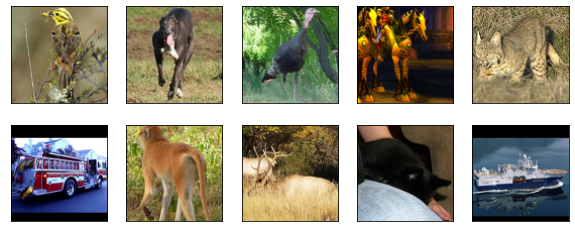

In [ ]:
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    img, label = dataset[idx]
    plt.imshow(img.permute((1, 2, 0)))

image indices: [ 234 1964 3945 1274]
torch.Size([3, 100, 394])


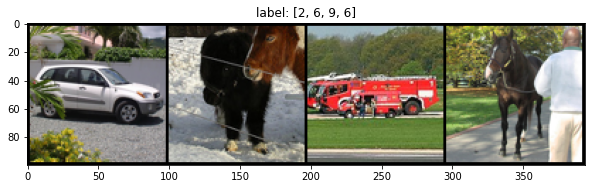

In [ ]:
def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid= make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [4036 3147 4658  622]
torch.Size([3, 100, 394])


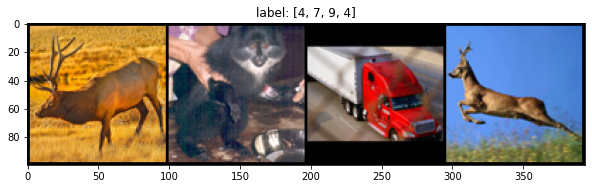

In [ ]:
grid_size=4
rnd_inds=np.random.randint(0,len(valid_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[valid_ds[i][0] for i in rnd_inds]
y_grid=[valid_ds[i][1] for i in rnd_inds]

x_grid= make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

#Preparing data for training

In [ ]:
# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))
train_tfms = tt.Compose([tt.RandomHorizontalFlip(p=0.5),
                         tt.RandomVerticalFlip(p=0.5), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         # tt.RandomCrop(96, padding=2, padding_mode='reflect'),
                         #tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds.transform =  train_tfms
valid_ds.transform =  valid_tfms

In [ ]:
batch_size= 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 2)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers = 2)

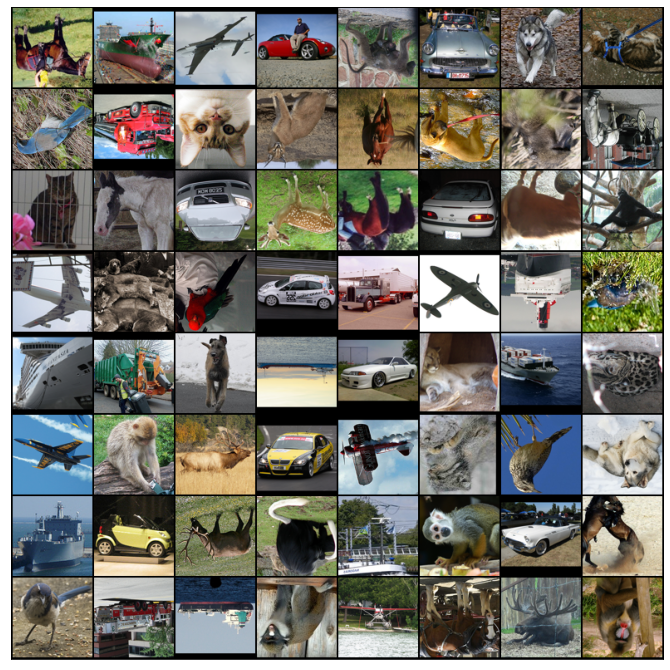

In [ ]:
#TO VISUALIZE OUT TRANSFORMATIONS ALSO NEED TO DENORMALIZE PIXEL VALUES
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(train_dl)

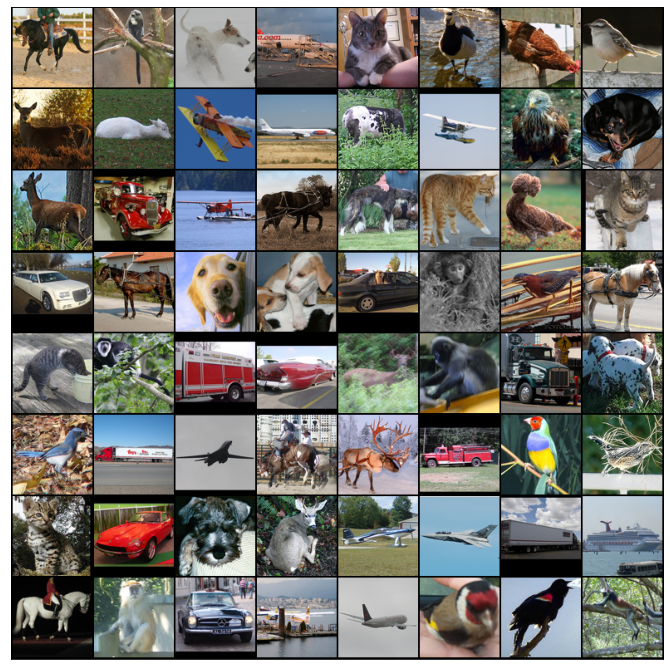

In [ ]:
show_batch(valid_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Creating a ResNet CNN Model

In [ ]:
'''
A simple Residual Block
'''
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([300, 3, 96, 96])


After each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # output: 64 x 96 x 96
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 48 x 48
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 24 x 24
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 12 x 12
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(12), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

#Training the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.0986328125, 'val_loss': 2.303438186645508}]

In [ ]:
epochs = 40
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#batch_size = 256 results, later reduced to 128 for self-supervised section
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00055, train_loss: 2.5022, val_loss: 1.9176, val_acc: 0.2702
Epoch [1], last_lr: 0.00101, train_loss: 1.7710, val_loss: 2.2310, val_acc: 0.2781
Epoch [2], last_lr: 0.00177, train_loss: 1.6450, val_loss: 2.5637, val_acc: 0.2611
Epoch [3], last_lr: 0.00276, train_loss: 1.5574, val_loss: 2.1704, val_acc: 0.3558
Epoch [4], last_lr: 0.00392, train_loss: 1.5056, val_loss: 1.4305, val_acc: 0.4681
Epoch [5], last_lr: 0.00516, train_loss: 1.4738, val_loss: 1.8330, val_acc: 0.3890
Epoch [6], last_lr: 0.00641, train_loss: 1.4278, val_loss: 1.4639, val_acc: 0.4888
Epoch [7], last_lr: 0.00758, train_loss: 1.4922, val_loss: 2.5566, val_acc: 0.3335
Epoch [8], last_lr: 0.00858, train_loss: 1.4687, val_loss: 1.7142, val_acc: 0.4679
Epoch [9], last_lr: 0.00935, train_loss: 1.5503, val_loss: 1.5512, val_acc: 0.4805
Epoch [10], last_lr: 0.00983, train_loss: 1.5108, val_loss: 1.5970, val_acc: 0.4364
Epoch [11], last_lr: 0.01000, train_loss: 1.3371, val_loss: 1.3356, val_acc: 0.5068
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

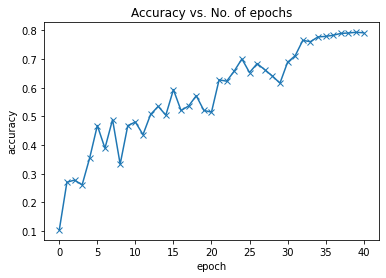

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

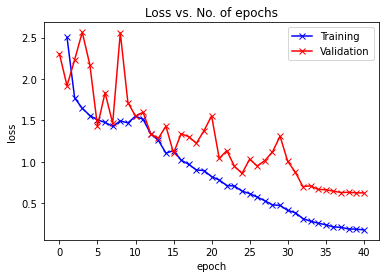

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

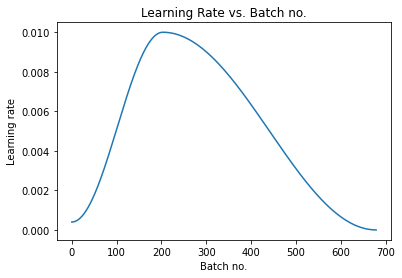

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: horse , Predicted: horse


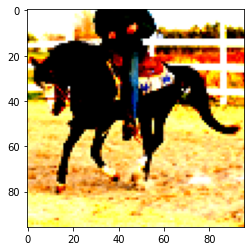

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ship , Predicted: ship


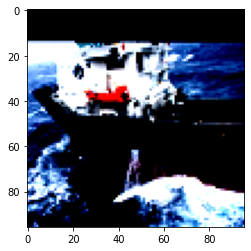

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: horse , Predicted: horse


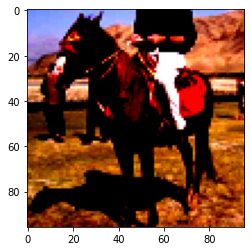

In [ ]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

#SEMI-SUPERVISED TRAINING

#Pseudo labeling framework
Use the trained model to predict labels on a batch of unlabeled data

Use the predicted labels to calculate the loss on unlabeled data

Combine labeled loss with unlabeled loss and backpropagate

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
unlabeled_dataset = STL10(root='data', split ='unlabeled', transform=tt.ToTensor())
unlabeled_dataset_size = len(unlabeled_dataset)
unlabeled_ds = unlabeled_dataset
unlabeled_dataset_size, unlabeled_ds.data.shape

(100000, (100000, 3, 96, 96))

In [ ]:
unlabeled_dl = DataLoader(unlabeled_ds, batch_size, shuffle=True, num_workers = 2)

In [ ]:
from tqdm import tqdm
'''
Hyperparameters for semi-supervised learning
'''
T1 = 40
T2 = 280
af = 3

In [ ]:
def alpha_weight(step):
    if step < T1:
        return 0.0
    elif step > T2:
        return af
    else:
         return ((step-T1) / (T2-T1))*af

In [ ]:
acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []

In [ ]:
def evaluate(model, valid_dl):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in valid_dl:
            data = data.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels.cuda()).sum()
            loss += F.nll_loss(output, labels.cuda()).item()

    return (float(correct)/len(valid_ds)) *100, (loss/len(valid_dl))

In [ ]:
def semisup_train(model, train_dl, unlabeled_dl, valid_dl):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    EPOCHS = 100
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 40 
    
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_dl):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            
            # """ ONLY FOR VISUALIZATION"""
            # if (batch_idx < 3) and (epoch % 10 == 0):
            #     unlabel.append(x_unlabeled.cpu())
            #     pseudo_label.append(pseudo_labeled.cpu())
            # """ ********************** """
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 100 batches train one epoch on labeled data 
            if batch_idx % 100 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_dl):
                    X_batch = X_batch.cuda()
                    y_batch = y_batch.cuda()
                    output = model(X_batch)
                    labeled_loss = F.nll_loss(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        test_acc, test_loss =evaluate(model, valid_dl)
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
            
        # """ LOGGING VALUES """
        # alpha_log.append(alpha_weight(step))
        # test_acc_log.append(test_acc/100)
        # test_loss_log.append(test_loss)
        # """ ************** """
        model.train()


In [ ]:
semisup_train(model, train_dl, unlabeled_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 : Alpha Weight : 0.10000 | Test Acc : 10.00000 | Test Loss : nan 


In [ ]:
test_acc, test_loss = evaluate(model, test_dl)
print('Test Acc : {:.5f} | Test Loss : {:.3f} '.format(test_acc, test_loss))
torch.save(net.state_dict(), 'saved_models/semi_supervised_weights')